In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
from xml.sax import xmlreader
import numpyro.distributions as dist
from hbmep.model import Baseline


class RectifiedLogistic(Baseline):
    LINK = "rectified_logistic"

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, l, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -l + jnp.true_divide(
                    H + l,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + l, l),
                                v
                            ),
                            jnp.exp(-b * (x - a))
                        ),
                        1 / v
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_l = numpyro.sample("global_sigma_l", dist.HalfNormal(100))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            # global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=5))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1 / 10))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_l_raw = numpyro.sample("sigma_l_raw", dist.HalfNormal(scale=1))
                sigma_l = numpyro.deterministic("sigma_l", global_sigma_l * sigma_l_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                # sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                # sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                    l = numpyro.deterministic("l", sigma_l * l_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    # p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    # p = numpyro.deterministic("p", sigma_p * p_raw)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        intensity,
                        a[subject, feature0],
                        b[subject, feature0],
                        v[subject, feature0],
                        L[subject, feature0],
                        l[subject, feature0],
                        H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu + 1)
                )
                # beta = numpyro.deterministic(
                #     site.beta,
                #     jnp.where(
                #         jnp.less(intensity, a[subject, feature0]),
                #         g_1[subject, feature0],
                #         jnp.true_divide(g_2[subject, feature0], mu + 1)
                #     )
                # )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=1 + jnp.multiply(mu, beta), rate=beta),
                    obs=response_obs
                )


In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/link-comparison/proc-2023-10-27/prime/rectified_logistic.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "mode")

config.MCMC_PARAMS["num_warmup"] = 500
config.MCMC_PARAMS["num_samples"] = 1000

model = RectifiedLogistic(config=config)



2023-11-03 16:18:48,888 - hbmep.config - INFO - Verifying configuration ...
2023-11-03 16:18:48,889 - hbmep.config - INFO - Success!
2023-11-03 16:18:48,904 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc_proc-2023-10-27.csv"
df = pd.read_csv(src)

# subset = ["SCA01", "SCA03", "SCA04", "SCA07"]
# ind = df[model.subject].isin(subset)
# df = df[ind].reset_index(drop=True).copy()


df, encoder_dict = model.load(df=df)


2023-11-03 16:18:49,011 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/prime/rectified_logistic/mode
2023-11-03 16:18:49,011 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/prime/rectified_logistic/mode
2023-11-03 16:18:49,012 - hbmep.dataset.core - INFO - Processing data ...
2023-11-03 16:18:49,013 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-03 16:18:49,101 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-03 15:05:09,016 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-11-03 15:05:12,067 - hbmep.utils.utils - INFO - func:predict took: 3.05 sec
2023-11-03 15:05:12,075 - hbmep.model.baseline - INFO - Rendering ...
2023-11-03 15:05:14,965 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/prime/rectified_logistic/mode/recruitment_curves.pdf
2023-11-03 15:05:14,966 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.90 sec
2023-11-03 15:05:14,981 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-11-03 15:05:18,134 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/proc-2023-10-27/prime/rectified_logistic/mode/posterior_predictive_check.pdf
2023-11-03 15:05:18,134 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 3.17 sec
2023-11-03 15:05:18,135 - hbmep.utils.utils - INFO - func:render_predictive_check took: 3.17 sec


In [ ]:
mcmc.print_summary(prob=.95)



                         mean       std    median      2.5%     97.5%     n_eff     r_hat
       H_raw[0,0,0]      0.78      0.61      0.64      0.01      2.00    176.47      1.02
       H_raw[0,1,0]      0.31      0.07      0.31      0.15      0.44     27.31      1.14
       H_raw[1,0,0]      0.77      0.57      0.66      0.00      1.94    236.71      1.03
       H_raw[1,1,0]      0.81      0.62      0.67      0.00      2.03    277.50      1.00
       H_raw[2,0,0]      0.90      0.63      0.78      0.00      2.03    110.09      1.03
       H_raw[2,1,0]      0.04      0.01      0.04      0.02      0.06     20.39      1.16
       H_raw[3,0,0]      0.84      0.59      0.74      0.01      1.98    282.39      1.03
       H_raw[3,1,0]      0.94      0.26      0.92      0.49      1.43     41.43      1.12
       H_raw[4,0,0]      0.68      0.58      0.52      0.00      1.88     70.88      1.09
       H_raw[4,1,0]      0.14      0.04      0.13      0.07      0.21     29.13      1.12
       H_

Text(0.5, 1.0, '0.9465')

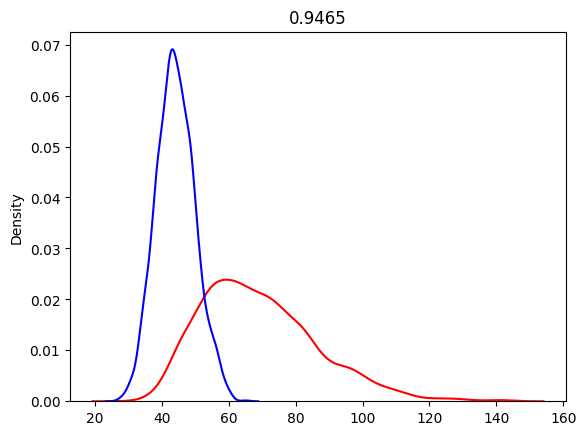

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

mu_a = posterior_samples[site.mu_a]
mu_a = np.array(mu_a)
mu_a.shape

sigma_a = posterior_samples[site.sigma_a]
sigma_a = np.array(sigma_a)
sigma_a.shape

loc = mu_a / sigma_a

sns.kdeplot(loc[:, 0, 0], color="red")
sns.kdeplot(loc[:, 1, 0], color="blue")
plt.title((loc[:, 1, 0] < loc[:, 0, 0]).mean())


In [37]:

obs.shape


(4000, 1600, 1)

<Axes: xlabel='TMSInt', ylabel='PKPK_APB'>

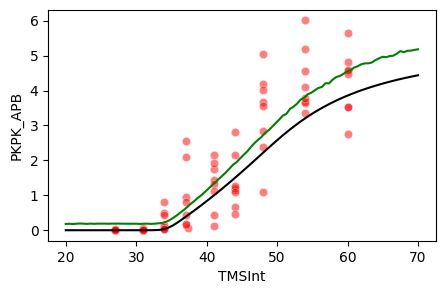

In [40]:
plt.figure(figsize=(5, 3))

mu = posterior_predictive[site.mu]
mu = np.array(mu)
mu.shape

obs = posterior_predictive[site.obs]
obs = np.array(obs)

c = (8, 1)
ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

ind = prediction_df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_pred_df = prediction_df[ind].reset_index(drop=True).copy()
temp_mu = mu[:, ind, 0]
temp_obs = obs[:, ind, 0]

sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[0]], color="red", alpha=.5)
sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color="black")
sns.lineplot(x=temp_pred_df[model.intensity], y=temp_obs.mean(axis=0), color="green")


In [20]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

loo = az.loo(numpyro_data)
logger.info(f"ELPD LOO (Log): {loo.elpd_loo:.2f}")

waic = az.waic(numpyro_data)
logger.info(f"ELPD WAIC (Log): {waic.elpd_waic:.2f}")


2023-11-03 15:28:36,386 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-03 15:28:37,908 - __main__ - INFO - ELPD LOO (Log): 1134.32
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-11-03 15:28:37,965 - __main__ - INFO - ELPD WAIC (Log): 1138.72


In [42]:
loo = az.loo(numpyro_data, var_name=site.obs)
loo


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 1112 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1134.32    87.67
p_loo      124.31        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1090   98.0%
 (0.5, 0.7]   (ok)         10    0.9%
   (0.7, 1]   (bad)         7    0.6%
   (1, Inf)   (very bad)    5    0.4%

In [ ]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)


In [ ]:
dest = os.path.join(model.build_dir, "numpyro_data.nc")
az.to_netcdf(numpyro_data, dest)


'/home/vishu/repos/hbmep-paper/reports/paper/tms/link-comparison/rectified_logistic/numpyro_data.nc'